#**Import Libraries**

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2354c185-8c70-23b3-4c91-100c8d4f7ebd)


In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import random
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
import cv2


from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras

In [ ]:
print( f"Python {sys.version}\n" )
print( f"NumPy {np.__version__}\n" )
%matplotlib inline
print(f'The scikit-learn version is {sklearn.__version__}')
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

NumPy 1.25.2

The scikit-learn version is 1.2.2
TensorFlow 2.15.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
seed=567
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def load_and_preprocess_images(folder_path, label, desired_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):  # Adjust if you have other formats
            file_destination = os.path.join(folder_path, filename)
            img = cv2.imread(file_destination)
            RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resized_img = cv2.resize(RGB_img, desired_size)
            images.append(resized_img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
!ls '/content/drive/MyDrive/dataset'

'Varanus dumerilii'  'Varanus nebulosus'  'Varanus rudicollis'	'Varanus salvator'


In [ ]:
x0, y0 = load_and_preprocess_images('/content/drive/My Drive/dataset/Varanus nebulosus', label=0) #ตะกวด
x1, y1 = load_and_preprocess_images('/content/drive/My Drive/dataset/Varanus dumerilii', label=1) #ตุ๊ดตู่
x2, y2 = load_and_preprocess_images('/content/drive/My Drive/dataset/Varanus rudicollis', label=2) #เห่าช้าง
x3, y3 = load_and_preprocess_images('/content/drive/My Drive/dataset/Varanus salvator', label=3) #ตัวเงินตัวทอง

In [ ]:
print(f"Shape of x0: {x0.shape}")
print(f"Shape of x1: {x1.shape}")
print(f"Shape of x2: {x2.shape}")
print(f"Shape of x3: {x3.shape}")

Shape of x0: (100, 224, 224, 3)
Shape of x1: (100, 224, 224, 3)
Shape of x2: (100, 224, 224, 3)
Shape of x3: (100, 224, 224, 3)


In [ ]:
print(y0.shape)
print(y1.shape)
print(y2.shape)
print(y3.shape)

(100,)
(100,)
(100,)
(100,)


In [ ]:
x = np.concatenate((x0, x1, x2, x3), axis=0)
y = np.concatenate((y0, y1, y2, y3), axis=0)
print(x.shape)
print(y.shape)

(400, 224, 224, 3)
(400,)


In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split

x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=seed, stratify=y_temp)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(256, 224, 224, 3)
(256,)
(64, 224, 224, 3)
(64,)
(80, 224, 224, 3)
(80,)


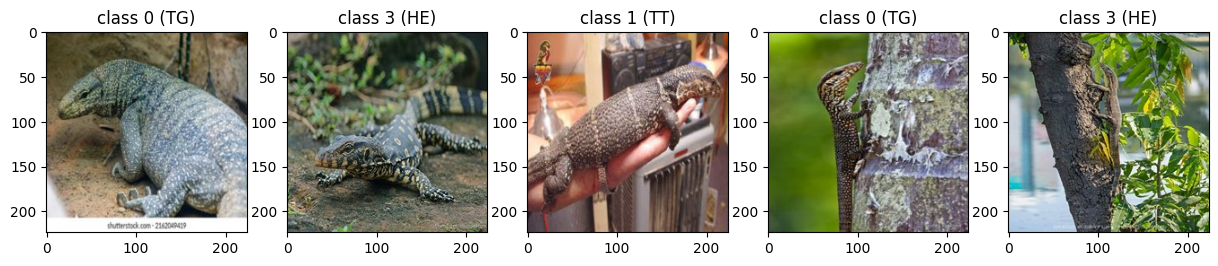

In [ ]:
# #visualize the first 5 image
label = ['TG','TT', 'HC','HE']
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_train[i]} ({label[y_train[i]]})')
  plt.imshow(x_train[i])
plt.show()

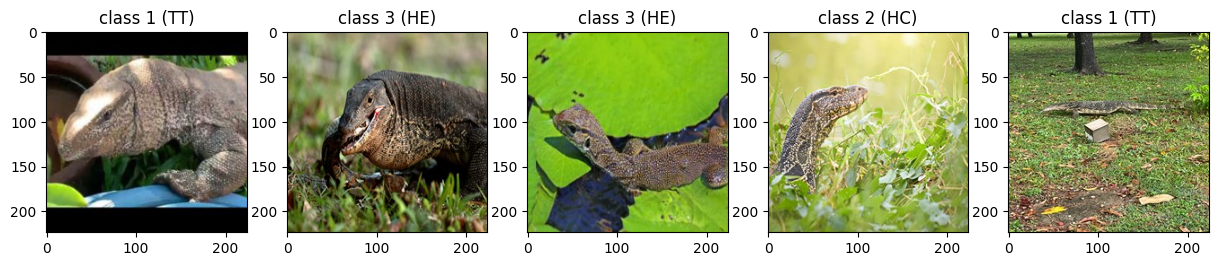

In [ ]:
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_test[i]} ({label[y_test[i]]})')
  plt.imshow(x_val[i])
plt.show()

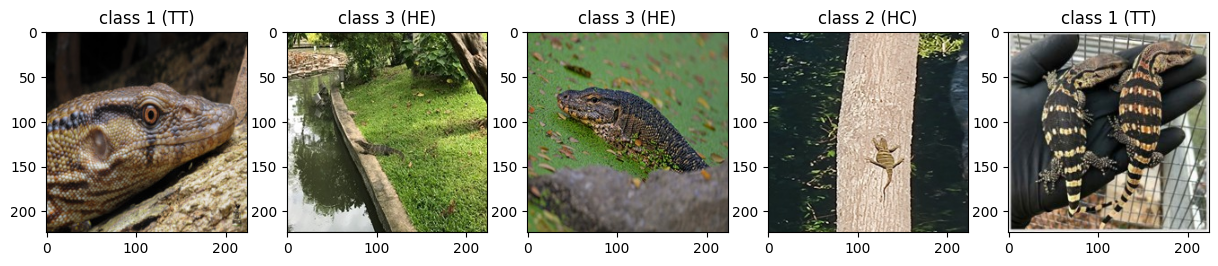

In [ ]:
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_test[i]} ({label[y_test[i]]})')
  plt.imshow(x_test[i])
plt.show()

#**Select Pre-Trained Model**

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions

ef50_extractor = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
ef50_extractor.trainable = False
ef50_extractor.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 normalization_4 (Normaliza  (None, 224, 224, 3)          0         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizatio

In [ ]:
#tf.keras.utils.plot_model(ef_ext, to_file = 'ef_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

In [ ]:
#Iterate over all layers in the model
for i, layer in enumerate(ef50_extractor.layers):
  print(f'Layer {i+1}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 1: Name = input_5, Trainable = False
Layer 2: Name = rescaling_4, Trainable = False
Layer 3: Name = normalization_4, Trainable = False
Layer 4: Name = stem_conv, Trainable = False
Layer 5: Name = stem_bn, Trainable = False
Layer 6: Name = stem_activation, Trainable = False
Layer 7: Name = block1a_project_conv, Trainable = False
Layer 8: Name = block1a_project_bn, Trainable = False
Layer 9: Name = block1a_project_activation, Trainable = False
Layer 10: Name = block2a_expand_conv, Trainable = False
Layer 11: Name = block2a_expand_bn, Trainable = False
Layer 12: Name = block2a_expand_activation, Trainable = False
Layer 13: Name = block2a_project_conv, Trainable = False
Layer 14: Name = block2a_project_bn, Trainable = False
Layer 15: Name = block2b_expand_conv, Trainable = False
Layer 16: Name = block2b_expand_bn, Trainable = False
Layer 17: Name = block2b_expand_activation, Trainable = False
Layer 18: Name = block2b_project_conv, Trainable = False
Layer 19: Name = block2b_project_bn

#**Data Augmentation**

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

x_train_ef = preprocess_input(x_train)
x_test_ef = preprocess_input(x_test)
x_val_ef = preprocess_input(x_val)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_ef, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_ef, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_ef, y_test))

In [ ]:
# Define data augmentation pipeline
dataaug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1)
])

In [ ]:
train_datagen = train_dataset.map(lambda x, y: (dataaug(x, training=True), y))

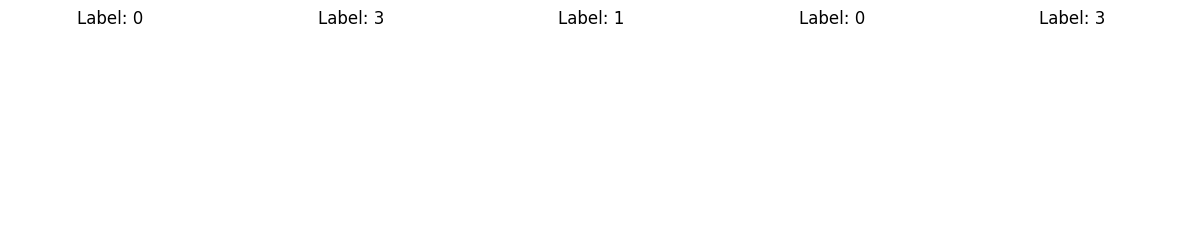

In [ ]:
# Define a function to plot images from the dataset
def plot_images(train_datagen, num_images=5):
    plt.figure(figsize=(15, 10))
    for images, labels in train_datagen.take(1):  # Take one batch
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            image = tf.squeeze(images[i]).numpy()  # Remove the batch dimension
            plt.imshow(image)
            plt.title(f'Label: {labels[i].numpy()}')
            plt.axis('off')
    plt.show()

# Create a batched dataset for visualization (batch size 5)
batched_dataset = train_datagen.batch(5)

# Plot images from the dataset
plot_images(batched_dataset)

#**Main Network**

In [ ]:
x = ef50_extractor.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
new_outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

# Construct the main model
model = tf.keras.models.Model(inputs=ef50_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_211"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 normalization_4 (Normaliza  (None, 224, 224, 3)          0         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization_4[0][0

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
checkpoint_filepath = "bestweights.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only=True)

In [ ]:
epochs = 100
batch_size = 32

In [ ]:
"""from livelossplot import PlotLossesKeras
from livelossplot.outputs import MatplotlibPlot

# Example codes in https://github.com/stared/livelossplot/blob/master/examples/matplotlib.ipynb
# Read about MatplotlibPlot() in https://github.com/stared/livelossplot/blob/master/livelossplot/outputs/matplotlib_plot.py
liveplot = PlotLossesKeras(outputs=[MatplotlibPlot(cell_size=(6,2))])"""

'from livelossplot import PlotLossesKeras\nfrom livelossplot.outputs import MatplotlibPlot\n\n# Example codes in https://github.com/stared/livelossplot/blob/master/examples/matplotlib.ipynb\n# Read about MatplotlibPlot() in https://github.com/stared/livelossplot/blob/master/livelossplot/outputs/matplotlib_plot.py\nliveplot = PlotLossesKeras(outputs=[MatplotlibPlot(cell_size=(6,2))])'

In [ ]:
history = model.fit(train_datagen.batch(batch_size),
                    epochs=epochs,
                    validation_data=val_dataset.batch(batch_size),
                     callbacks=model_checkpoint_callback,
                    verbose=1)

Epoch 1/100
8/8 [==============================] - 14s 614ms/step - loss: 63.5923 - accuracy: 0.3203 - val_loss: 11.5365 - val_accuracy: 0.3750
Epoch 2/100
8/8 [==============================] - 4s 473ms/step - loss: 7.0942 - accuracy: 0.4609 - val_loss: 3.1108 - val_accuracy: 0.5312
Epoch 3/100
8/8 [==============================] - 4s 477ms/step - loss: 3.5216 - accuracy: 0.5547 - val_loss: 2.3842 - val_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 3s 426ms/step - loss: 2.1008 - accuracy: 0.6055 - val_loss: 2.0288 - val_accuracy: 0.5469
Epoch 5/100
8/8 [==============================] - 3s 424ms/step - loss: 3.2823 - accuracy: 0.6172 - val_loss: 1.9540 - val_accuracy: 0.5625
Epoch 6/100
8/8 [==============================] - 4s 454ms/step - loss: 1.2695 - accuracy: 0.6992 - val_loss: 1.5698 - val_accuracy: 0.5781
Epoch 7/100
8/8 [==============================] - 3s 425ms/step - loss: 1.1770 - accuracy: 0.7500 - val_loss: 1.1566 - val_accuracy: 0.6719
Epoch 8/10

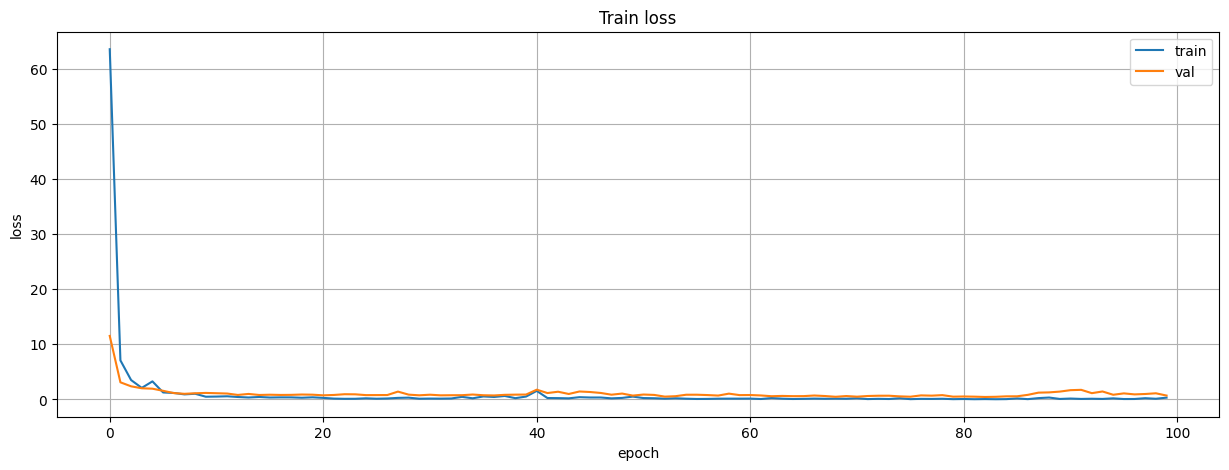

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

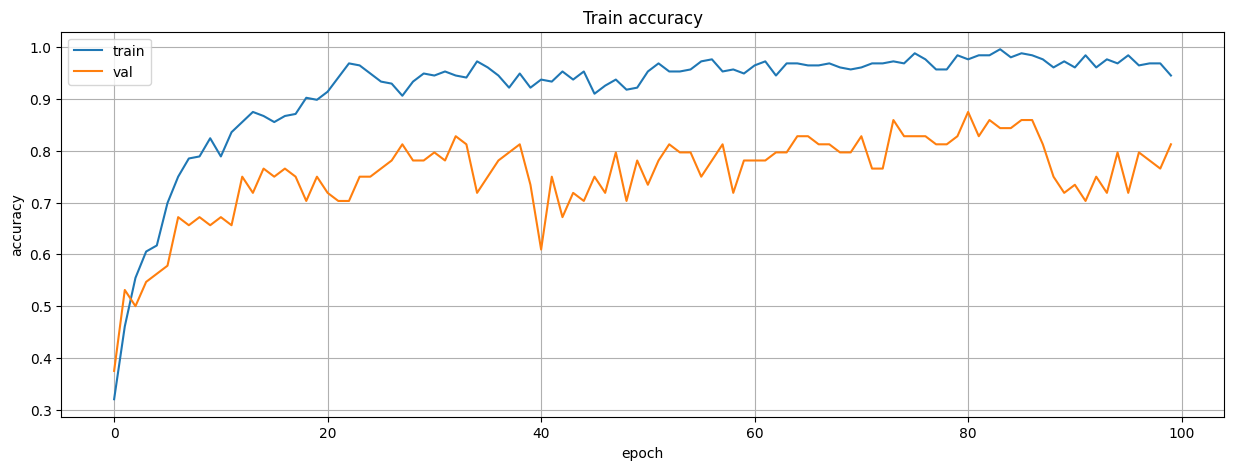

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'])  # เปลี่ยนจาก 'acc' เป็น 'accuracy'
plt.plot(history.history['val_accuracy'])  # เปลี่ยนจาก 'val_acc' เป็น 'val_accuracy'
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

#**Evalutate Model**

In [ ]:
model.load_weights("bestweights.hdf5")
results = model.evaluate(x_test_ef, y_test, batch_size=128)
print(f'{model.metrics_names}: {results}')

1/1 [==============================] - 0s 139ms/step - loss: 1.2950 - accuracy: 0.8125
['loss', 'accuracy']: [1.2950074672698975, 0.8125]


In [ ]:
y_pred = []
for i in range(len(x_test_ef)):
    x_input = x_test_ef[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input)))

1/1 [==============================] - 0s 24ms/step


In [ ]:
from sklearn.metrics import classification_report

# Assuming y_test and y_pred are already defined
target_names = ['TG', 'TT', 'HC', 'HE']
report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

# Print the full report
print("Classification Report:")
print(report)



Classification Report:
{'TG': {'precision': 0.6956521739130435, 'recall': 0.8, 'f1-score': 0.7441860465116279, 'support': 20}, 'TT': {'precision': 0.85, 'recall': 0.85, 'f1-score': 0.85, 'support': 20}, 'HC': {'precision': 0.7894736842105263, 'recall': 0.75, 'f1-score': 0.7692307692307692, 'support': 20}, 'HE': {'precision': 0.9444444444444444, 'recall': 0.85, 'f1-score': 0.8947368421052632, 'support': 20}, 'accuracy': 0.8125, 'macro avg': {'precision': 0.8198925756420037, 'recall': 0.8125, 'f1-score': 0.8145384144619151, 'support': 80}, 'weighted avg': {'precision': 0.8198925756420035, 'recall': 0.8125, 'f1-score': 0.814538414461915, 'support': 80}}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of samples
n = 10
samples = x_test[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Define color_frame function
def color_frame(ax, y_true, y_pred):
    color = 'green' if y_true == y_pred else 'red'
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(3)

# Interpret and display the results
for i in range(n):
    plt.figure(figsize=(3,3), dpi=90)
    ax = plt.gca()
    plt.imshow(samples[i].reshape(224, 224, 3))  # Display in color
    plt.title(f"x_test[{i}]: y_true={y_test[i]} , y_pred={np.argmax(y_pred[i])}")
    color_frame(ax, y_test[i], np.argmax(y_pred[i]))
    plt.show()


#**Grad-CAM**

In [ ]:
from matplotlib import cm as cmp
from PIL import Image

In [ ]:
# Define species labels
species_labels = {
    0: 'Varanus nebulosus (ตะกวด)',
    1: 'Varanus dumerilii (ตุ๊ดตู่)',
    2: 'Varanus rudicollis (เห่าช้าง)',
    3: 'Varanus salvator'
}

In [ ]:
# Preprocess function and last conv layer name
preprocess_input = keras.applications.efficientnet.preprocess_input
last_conv_layer_name = "top_conv"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cmp.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

# Function to display original and resized Grad-CAM side by side with color scales and tick marks
def display_side_by_side(original_heatmap, resized_heatmap, input_image):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Original heatmap
    cax1 = ax1.imshow(original_heatmap, cmap='jet')
    ax1.set_title('Original Grad-CAM')
    fig.colorbar(cax1, ax=ax1)
    ax1.set_xticks(np.arange(original_heatmap.shape[1]))
    ax1.set_yticks(np.arange(original_heatmap.shape[0]))

    # Resized heatmap on the input image
    ax2.imshow(input_image)
    cax2 = ax2.imshow(resized_heatmap, cmap='jet', alpha=0.4)
    ax2.set_title('Resized Grad-CAM on an input image')
    fig.colorbar(cax2, ax=ax2)
    ax2.set_xticks(np.arange(input_image.shape[1], step=25))
    ax2.set_yticks(np.arange(input_image.shape[0], step=25))

    plt.show()

for i in range(len(x_test_ef)):
    img = x_test_ef[i]
    img_array = preprocess_input(img)

    model.layers[-1].activation = None
    preds = model.predict(img_array.reshape(-1, 224, 224, 3))
    predicted_label = np.argmax(preds)
    true_label = y_test[i]

    # Check if prediction is correct before proceeding
    if predicted_label == true_label:
        print(f"Predicted: {species_labels[predicted_label]} | Actual: {species_labels[true_label]}")

        heatmap = make_gradcam_heatmap(img_array.reshape(1, 224, 224, 3), model, last_conv_layer_name)

        # Display the side-by-side comparison
        resized_heatmap = np.array(Image.fromarray(heatmap).resize((img.shape[1], img.shape[0])))
        display_side_by_side(heatmap, resized_heatmap, img)

In [ ]:
def plot_all_images(x_test_ef, y_test, num_images=80):
    plt.figure(figsize=(15, 20))
    for i in range(num_images):
        plt.subplot(8, 10, i + 1)  # 8 rows and 10 columns for a total of 80 images
        plt.imshow(x_test_ef[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_all_images(x_test_ef, y_test, num_images=80)